In [194]:
import pandas as pd
# read in files
# Read UK_df.csv as pandas dataframe
original_UK_dialogue = pd.read_csv('UK_df.csv')
original_UK_politeness = pd.read_csv('UK_direct_df.csv')
original_UK_narrator = pd.read_csv('UK_narrator_df.csv')
original_US_dialogue = pd.read_csv('US_df.csv')
original_US_politeness = pd.read_csv('US_direct_df.csv')
original_US_narrator = pd.read_csv('US_narrator_df.csv')
dataframes = [original_UK_dialogue, original_UK_politeness, original_UK_narrator, original_US_dialogue, original_US_politeness, original_US_narrator]
def elim_outliers(df):
    # dropped Unnamed: 0 column
    df.drop(columns=['Unnamed: 0'], inplace=True)
    filtered_df = df.loc[(df['response'] > 95) | (df['response'] < 5)]
    for id in df['person_id'].unique():
        if len(filtered_df[filtered_df['person_id'] == id])/len(df[df['person_id'] == id])>0.8:
            df.drop(df[df['person_id'] == id].index, inplace=True)
    df['predicate Z-score'] = df.groupby(['person_id','predicate'])['response'].transform(lambda x: (x - x.mean()) / x.std())
    # if has_intensifier = no then change 'intensifier' to 'none'
    df.loc[df['has intensifier?'] == 'no', 'intensifier'] = 'none'
    return df
for i in range(len(dataframes)):
    dataframes[i] = elim_outliers(dataframes[i])
dialogue = pd.concat([dataframes[0], dataframes[3]])
politeness = pd.concat([dataframes[1], dataframes[4]])
UK_dialogue = dataframes[0]
US_dialogue = dataframes[3]
UK_politeness = dataframes[1]
US_politeness = dataframes[4]

# end of reading in data
#-------------------------------------------------------------------------------

# compute U_soc (social Utility)
U_soc_data = politeness.groupby(['intensifier','predicate'])['predicate Z-score'].mean().to_dict()
UK_U_soc_data = UK_politeness.groupby(['intensifier','predicate'])['predicate Z-score'].mean().to_dict()
US_U_soc_data = US_politeness.groupby(['intensifier','predicate'])['predicate Z-score'].mean().to_dict()

In [195]:
from memo import memo
import jax
import jax.numpy as np
from enum import IntEnum, auto

Define constants

In [196]:
epsilon = 0.01
infty = 10000000
utterences =list(U_soc_data.keys())
state_values = np.arange(-2.8,2.8,0.28)
S = np.arange(0,20,1)

Define params to iterate

In [ ]:
theta_to_test = np.arange(0,20,1)
possible_inf_terms = np.arange(0,5,0.5)
possible_soc_terms = np.arange(0,5,0.5)
costs = np.arange(0,5,0.5)

In [198]:
class W(IntEnum):  # utterance space
    # intensifiers
    none = auto(0)
    slightly= auto()
    kind_of = auto()
    quite = auto()
    very= auto()
    extremely= auto()
class P(IntEnum):
    # predicates
    boring = auto(0)
    concerned = auto()
    difficult = auto()
    exhausted = auto()
    helpful = auto()
    impressive = auto()
    understandable = auto()
    

Construct measured_values which is an array of 42 arrays where the i'th entry is the values people reported for the i'th utterance

In [199]:
possible_literal_semantics = np.array(
    [
        np.concatenate([np.repeat(np.array([epsilon]),i),np.repeat(np.array([1]),20-i)])
        for i in range(20)
    ]
)
@jax.jit
def state_prior(s):
    return np.float32(np.exp(-state_values[s]**2/2))  # uninformative state prior doesn't matter that it doesn't add up to 1
@jax.jit
def U_soc(intensifier,predicate):
    arr = np.array([
        [U_soc_data[(w.name.replace('_'," "),p.name)] for p in P] 
        for w in W
    ])
    return arr[intensifier,predicate]
@jax.jit
def UK_U_soc(intensifier,predicate):
    arr = np.array([
        [UK_U_soc_data[(w.name.replace('_'," "),p.name)] for p in P] 
        for w in W
    ])
    return arr[intensifier,predicate]
@jax.jit
def US_U_soc(intensifier,predicate):
    arr = np.array([
        [US_U_soc_data[(w.name.replace('_'," "),p.name)] for p in P] 
        for w in W
    ])
    return arr[intensifier,predicate]
@jax.jit
def is_costly(w):
    arr = [0, 1, 1, 1, 1, 1]
    return np.array(arr)[w]

@jax.jit
def L(w, s,t0,t1,t2,t3,t4,t5):  # literal likelihood L(w | s)
    intensifier_semantics = np.array([  # "hard semantics"
        possible_literal_semantics[t0],  # none
        possible_literal_semantics[t1],  # slightly 
        possible_literal_semantics[t2],  # kind of
        possible_literal_semantics[t3],  # quite
        possible_literal_semantics[t4],  # very
        possible_literal_semantics[t5],  # extremely
    ])
    return intensifier_semantics[w,s]  # "hard semantics"

@memo
def L1[s: S, w: W](inf_term, soc_term, cost,t0,t1,t2,t3,t4,t5,p):
    listener: thinks[
        speaker: given(s in S, wpp=state_prior(s)),
        speaker: chooses(w in W, wpp=
            imagine[
                listener: knows(w),
                listener: chooses(s in S, wpp=L(w, s,t0,t1,t2,t3,t4,t5)) ,
                exp(inf_term * log(Pr[listener.s == s]) + 
                soc_term * U_soc(w,p) - # U_soc = listener's EU
                cost*is_costly(w)) # U_inf = listener's surprisal       
            ]
        )
    ]
    listener: observes[speaker.w] is w
    listener: chooses(s in S, wpp=Pr[speaker.s == s])
    return Pr[listener.s == s]
@memo
def UKL1[s: S, w: W](inf_term, soc_term, cost,t0,t1,t2,t3,t4,t5,p):
    listener: thinks[
        speaker: given(s in S, wpp=state_prior(s)),
        speaker: chooses(w in W, wpp=
            imagine[
                listener: knows(w),
                listener: chooses(s in S, wpp=L(w, s,t0,t1,t2,t3,t4,t5)) ,
                exp(inf_term * log(Pr[listener.s == s]) + 
                soc_term * UK_U_soc(w,p) - # U_soc = listener's EU
                cost*is_costly(w)) # U_inf = listener's surprisal       
            ]
        )
    ]
    listener: observes[speaker.w] is w
    listener: chooses(s in S, wpp=Pr[speaker.s == s])
    return Pr[listener.s == s]
@memo
def USL1[s: S, w: W](inf_term, soc_term, cost,t0,t1,t2,t3,t4,t5,p):
    listener: thinks[
        speaker: given(s in S, wpp=state_prior(s)),
        speaker: chooses(w in W, wpp=
            imagine[
                listener: knows(w),
                listener: chooses(s in S, wpp=L(w, s,t0,t1,t2,t3,t4,t5)) ,
                exp(inf_term * log(Pr[listener.s == s]) + 
                soc_term * US_U_soc(w,p) - # U_soc = listener's EU
                cost*is_costly(w)) # U_inf = listener's surprisal       
            ]
        )
    ]
    listener: observes[speaker.w] is w
    listener: chooses(s in S, wpp=Pr[speaker.s == s])
    return Pr[listener.s == s]

In [200]:
# Create a list of JAX arrays
UK_measured_values = []
for p in P:
    for w in W:
        intensifier = w.name.replace('_'," ")
        predicate = p.name
        raw_values = UK_dialogue[((UK_dialogue['intensifier'] == intensifier) & (UK_dialogue['predicate'] == predicate))]['predicate Z-score'].values
        # measured_values.append(np.array([int(r/0.28)+10 for r in raw_values]))
        z = [int(r/0.28)+10 for r in raw_values]
        x = [0]*len(S)
        for i in z:
            x[i] += 1
        UK_measured_values.append(x)
UK_measured_values = np.array(UK_measured_values)
# Create a list of JAX arrays
US_measured_values = []
for p in P:
    for w in W:
        intensifier = w.name.replace('_'," ")
        predicate = p.name 
        raw_values = US_dialogue[((US_dialogue['intensifier'] == intensifier) & (US_dialogue['predicate'] == predicate))]['predicate Z-score'].values
        # measured_values.append(np.array([int(r/0.28)+10 for r in raw_values]))
        z = [int(r/0.28)+10 for r in raw_values]
        x = [0]*len(S)
        for i in z:
            x[i] += 1
        US_measured_values.append(x)
US_measured_values = np.array(US_measured_values)
def compute_logloss(*params):
    thetas = params[:6]
    cost = params[6]
    inf_term = params[7]
    soc_term = params[8]
    # compute fit e.g. log_likelihood
    P_l1 = np.concatenate([L1(inf_term=inf_term, soc_term=soc_term, cost=cost, t0 = thetas[0],t1=thetas[1], t2= thetas[2], t3 = thetas[3], t4 = thetas[4], t5 = thetas[5],p=p) for p in P],axis = 1)
    return np.sum(np.log(P_l1)*UK_measured_values.T),np.sum(np.log(P_l1)*US_measured_values.T)
def UK_soc_logloss(*params):
    thetas = params[:6]
    cost = params[6]
    inf_term = params[7]
    soc_term = params[8]
    # compute fit e.g. log_likelihood
    for p in P:
        for w in W:
            intensifier = w.name.replace('_'," ")
            predicate = p.name
            raw_values = UK_dialogue[((UK_dialogue['intensifier'] == intensifier) & (UK_dialogue['predicate'] == predicate))]['predicate Z-score'].values
            # measured_values.append(np.array([int(r/0.28)+10 for r in raw_values]))
            z = [int(r/0.28)+10 for r in raw_values]
            x = [0]*len(S)
            for i in z:
                x[i] += 1
    P_l1 = np.concatenate([UKL1(inf_term=inf_term, soc_term=soc_term, cost=cost, t0 = thetas[0],t1=thetas[1], t2= thetas[2], t3 = thetas[3], t4 = thetas[4], t5 = thetas[5],p=p) for p in P],axis = 1)
    return np.sum(np.log(P_l1)*UK_measured_values.T)
def US_soc_logloss(*params):
    thetas = params[:6]
    cost = params[6]
    inf_term = params[7]
    soc_term = params[8]
    # compute fit e.g. 
    for p in P:
        for w in W:
            intensifier = w.name.replace('_'," ")
            predicate = p.name
            raw_values = US_dialogue[((US_dialogue['intensifier'] == intensifier) & (US_dialogue['predicate'] == predicate))]['predicate Z-score'].values
            # measured_values.append(np.array([int(r/0.28)+10 for r in raw_values]))
            z = [int(r/0.28)+10 for r in raw_values]
            x = [0]*len(S)
            for i in z:
                x[i] += 1
    P_l1 = np.concatenate([USL1(inf_term=inf_term, soc_term=soc_term, cost=cost, t0 = thetas[0],t1=thetas[1], t2= thetas[2], t3 = thetas[3], t4 = thetas[4], t5 = thetas[5],p=p) for p in P],axis = 1)
    return np.sum(np.log(P_l1)*US_measured_values.T)

In [201]:
# # sum rows of UK_measured_values which are same mod 6
# import numpy as np
# # plot histogram of arr
# print(np.sum(UK_measured_values[1::6],axis=0))
# import matplotlib.pyplot as plt

# plt.plot(state_values,np.sum(US_measured_values[1::6],axis=0), marker = 'o',color='r', label="US")
# plt.plot(state_values,np.sum(UK_measured_values[1::6],axis=0), marker = 'o',color='b', label="UK")
# plt.legend()
# plt.xlabel('z-score threshold')
# plt.ylabel('count for dialogue scenario')
# plt.show()


In [202]:
total_param_combos = len(costs)*len(possible_soc_terms)*len(possible_inf_terms)*len(theta_to_test)**3
in_repeat = total_param_combos//len(theta_to_test)
out_repeat = 1
# first_thetas = np.repeat(np.tile(theta_to_test, in_repeat),out_repeat)
# out_repeat = out_repeat*len(theta_to_test)
# in_repeat = in_repeat//len(theta_to_test)
# second_thetas = np.repeat(np.tile(theta_to_test, in_repeat),out_repeat)
# out_repeat = out_repeat*len(theta_to_test)
# in_repeat = in_repeat//len(theta_to_test)
# third_thetas = np.repeat(np.tile(theta_to_test, in_repeat),out_repeat)
# out_repeat = out_repeat*len(theta_to_test)
# in_repeat = in_repeat//len(theta_to_test)
fourth_thetas = np.repeat(np.tile(theta_to_test, in_repeat),out_repeat)
out_repeat = out_repeat*len(theta_to_test)
in_repeat = in_repeat//len(theta_to_test)
fifth_thetas = np.repeat(np.tile(theta_to_test, in_repeat),out_repeat)
out_repeat = out_repeat*len(theta_to_test)
in_repeat = in_repeat//len(theta_to_test)
sixth_thetas = np.repeat(np.tile(theta_to_test, in_repeat),out_repeat)
out_repeat = out_repeat*len(theta_to_test)
in_repeat = in_repeat//len(costs)
seventh_costs = np.repeat(np.tile(costs, in_repeat),out_repeat)
out_repeat = out_repeat*len(costs)
in_repeat = in_repeat//len(possible_inf_terms)
eighth_infs = np.repeat(np.tile(possible_inf_terms, in_repeat),out_repeat)
out_repeat = out_repeat*len(possible_inf_terms)
in_repeat = in_repeat//len(possible_soc_terms)
ninth_socs = np.repeat(np.tile(possible_soc_terms, in_repeat),out_repeat)

In [205]:
# # compute UK specific result
# all_output = []
# for t1 in theta_to_test:
#     for t2 in theta_to_test:
#         for t3 in theta_to_test:
#             output= jax.vmap(UK_soc_logloss,in_axes=(None,)*3+(0,)*6)(t1,t2,t3,fourth_thetas,fifth_thetas,sixth_thetas,seventh_costs,eighth_infs,ninth_socs).block_until_ready()
#             all_output.append(output)
#         print(t1,t1)
# all_output = np.array(all_output).flatten()
# np.save(f'UK_specific_soc_march5.npy', all_output)
# del all_output
# # compute US specific result
# # compute UK specific result
# all_output = []
# for t1 in theta_to_test:
#     for t2 in theta_to_test:
#         for t3 in theta_to_test:
#             output= jax.vmap(US_soc_logloss,in_axes=(None,)*3+(0,)*6)(t1,t2,t3,fourth_thetas,fifth_thetas,sixth_thetas,seventh_costs,eighth_infs,ninth_socs).block_until_ready()
#             all_output.append(output)
#         print(t1,t2)
# all_output = np.array(all_output).flatten()
# np.save(f'US_specific_soc_march5.npy', all_output)
# del all_output
# compute UK/US specific result
UK_all_output = []
US_all_output = []
for t1 in theta_to_test:
    for t2 in theta_to_test:
        for t3 in theta_to_test:
            UK_output,US_output = jax.vmap(compute_logloss,in_axes=(None,)*3+(0,)*6)(t1,t2,t3,fourth_thetas,fifth_thetas,sixth_thetas,seventh_costs,eighth_infs,ninth_socs)
            UK_all_output.append(UK_output)
            US_all_output.append(US_output)
        print(t1,t2)
# save all_output to a file
UK_all_output = np.array(UK_all_output).flatten()
np.save(f'UK_standard_march5.npy', UK_all_output)
del UK_all_output
US_all_output = np.array(US_all_output).flatten()
np.save(f'US_standard_march5.npy', US_all_output)
del US_all_output

KeyboardInterrupt: 

Produce graph from ideal parameters

Experimenting

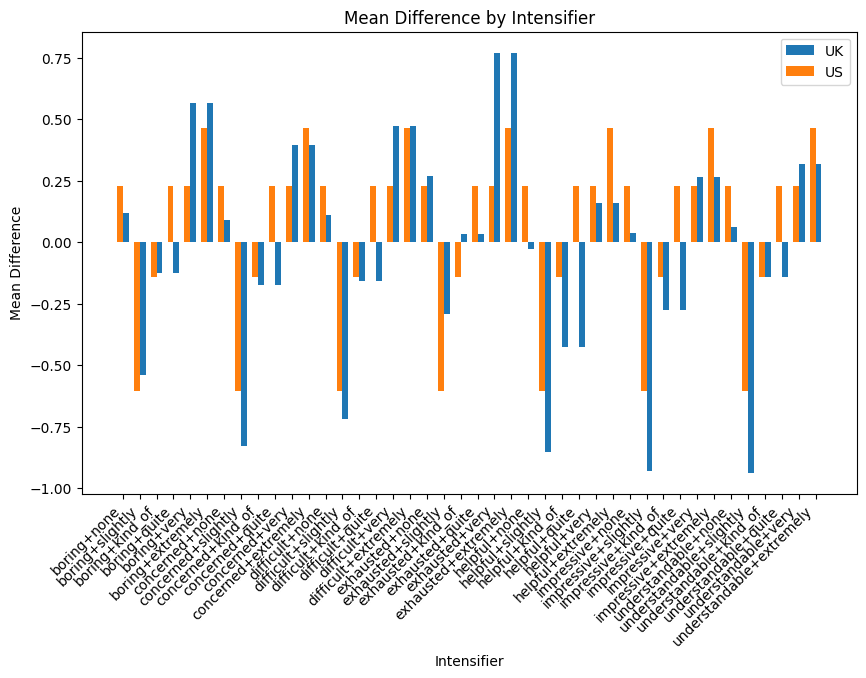

In [ ]:
# for utterence in W:
#     print(U_soc_key_map[utterence])
#     # Compute weighted mean
#     weighted_mean = np.average(state_values, weights=P_l1[:,utterence])

#     # Compute weighted variance
#     variance = np.average((state_values - weighted_mean) ** 2, weights=P_l1[:,utterence])
#     # Compute weighted standard deviation
#     std_dev = np.sqrt(variance)
# plot values next to eachother of each of values in new_US[('difference','mean')].keys()
# so x lables are new_US[('difference','mean')].keys() which are predicate intensifier pairs
# y values are new_US[('difference','mean')].values() and new_UK[('difference','mean')].values()
import matplotlib.pyplot as plt
import numpy as np
# US_soc_logloss(7,19,5,7,7,12,0,0.5,0)
cost = 0
inf_term = 0.6
soc_term = 0
thetas = [8,0,6,8,8,10] # these should be integers
P_l1 = np.concat([USL1(inf_term=inf_term, soc_term=soc_term, cost=cost, t0 = thetas[0],t1=thetas[1], t2= thetas[2], t3 = thetas[3], t4 = thetas[4], t5 = thetas[5],p=p) for p in P],axis=1)# note this should be P(s|w)
us_means = [np.average(state_values, weights=P_l1[:,u]) for u in range(len(P_l1[0]))]
us_std = [np.average((state_values - us_means[u]) ** 2, weights=P_l1[:,u]) for u in range(len(P_l1[0]))]
us_var = [us_std[u]**0.5 for u in W]

# specify ideal parameters for UK (coarser search)
thetas = [8,0,6,6,12,12] # these should be integers
cost = 0.6
inf_term = 0.6
soc_term = 2.4
# this is for UK version
P_l1 = np.concat([UKL1(inf_term=inf_term, soc_term=soc_term, cost=cost, t0 = thetas[0],t1=thetas[1], t2= thetas[2], t3 = thetas[3], t4 = thetas[4], t5 = thetas[5],p=p) for p in P],axis=1)# note this should be P(s|w)
uk_means = [np.average(state_values, weights=P_l1[:,u]) for u in range(len(P_l1[0]))]
uk_std = [np.average((state_values - uk_means[u]) ** 2, weights=P_l1[:,u]) for u in range(len(P_l1[0]))]
uk_var = [uk_std[u]**0.5 for u in W]
# Plotting
# convert range(48) to np array
x = np.array(range(42))  # X positions for bars
width = 0.35  # Width of the bars
fig, ax = plt.subplots(figsize=(10, 6))
bars_uk = ax.bar(x + width/2, uk_means, width, label='UK')
bars_us = ax.bar(x - width/2, us_means, width, label='US')

# # Add error bars
# ax.errorbar(x - width/2, us_means, us_std, fmt='none', ecolor='black', capsize=2)
# ax.errorbar(x + width/2, uk_means, uk_std, fmt='none', ecolor='black', capsize=2)
# remove the numbers on bar

# Add labels, title, and legend
ax.set_xlabel('Intensifier')
ax.set_ylabel('Mean Difference')
ax.set_title('Mean Difference by Intensifier')
ax.set_xticks(x)
ax.set_xticklabels([f'{p.name}+{utterence.name}' for p in P for utterence in W] , rotation=45, ha='right')
ax.legend()
plt.show()
